# Trajectory prediction using Cloud points and Past sensor data 

### 1. Introduction

This document presents a comprehensive approach to autonomous vehicle trajectory prediction using multimodal sensor fusion. The system combines sequential vehicle dynamics data with LiDAR point cloud information to predict future vehicle trajectories. The methodology employs deep learning architectures specifically designed for spatiotemporal data fusion, addressing the critical challenge of accurate motion prediction in autonomous driving scenarios.

### 2. Problem Formulation

The trajectory prediction problem is formulated as a sequence-to-sequence learning task where we predict future vehicle displacements based on historical vehicle states and environmental perception data.

#### Mathematical Formulation:

Given a sequence of historical vehicle states:
```
X_seq = {x₁, x₂, ..., x_T}
```
And corresponding LiDAR point cloud data:
```
P = {p₁, p₂, ..., p_N} where p_i ∈ ℝ⁴ (x, y, z, intensity)
```
The objective is to predict future relative displacements:
```
Y = {Δx₁, Δx₂, ..., Δx_H} where Δx_i = (δx_i, δy_i)
```
Where T is the sequence length, N is the number of LiDAR points, and H is the prediction horizon.

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import glob
from plyfile import PlyData
from tqdm import tqdm
import math

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

## load dataset 

In [5]:
data_path = './carla_data'  
ego_data_file = glob.glob(os.path.join(data_path, 'ego_data_*.csv'))[0]  # Get the first ego data file
lidar_path = os.path.join(data_path, 'lidar')

print(f"Loading ego data from: {ego_data_file}")
print(f"Loading LiDAR data from: {lidar_path}")

# Load ego vehicle data
ego_df = pd.read_csv(ego_data_file)
print(f"Loaded ego data with {len(ego_df)} timesteps")

Loading ego data from: ./carla_data\ego_data_20250505_190810baseTown.csv
Loading LiDAR data from: ./carla_data\lidar
Loaded ego data with 8136 timesteps


In [6]:
def load_lidar_point_cloud(file_path):
    """Load LiDAR point cloud from PLY file"""
    try:
        plydata = PlyData.read(file_path)
        x = plydata['vertex']['x']
        y = plydata['vertex']['y']
        z = plydata['vertex']['z']
        intensity = plydata['vertex']['intensity']
        
        # Stack points and intensity
        points = np.column_stack((x, y, z, intensity))
        return points
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return np.zeros((100, 4))  # Return empty array if there's an error

def sample_point_cloud(points, n_points=1024):
    """Sample a fixed number of points from point cloud with improved sampling strategy"""
    if len(points) == 0:
        return np.zeros((n_points, points.shape[1]))
    
    if len(points) >= n_points:
        # Focus sampling on points closer to the vehicle (more relevant for trajectory)
        # Calculate distance from origin (vehicle position)
        distances = np.sqrt(points[:, 0]**2 + points[:, 1]**2)
        
        # Create probability weights - higher probability for closer points
        # Add small constant to avoid division by zero
        weights = 1.0 / (distances + 0.1)
        weights /= np.sum(weights)  # Normalize
        
        # Sample points with weighted probability
        indices = np.random.choice(len(points), n_points, replace=False, p=weights)
        return points[indices]
    else:
        # If we have fewer points than needed, duplicate some points
        indices = np.random.choice(len(points), n_points, replace=True)
        return points[indices]

def process_point_cloud(points, max_points=1024):
    """Process point cloud data with improved normalization"""
    # Extract XYZ coordinates and intensity
    xyz = points[:, :3]
    
    # Center points to origin
    if len(xyz) > 0:
        # Use robust centering - center to median rather than mean
        center = np.median(xyz, axis=0)
        xyz = xyz - center
        
        # Scale to unit sphere using 90th percentile instead of max
        # This makes normalization more robust to outliers
        radii = np.sqrt(np.sum(xyz**2, axis=1))
        if len(radii) > 0:
            scale = np.percentile(radii, 90)
            if scale > 0:
                xyz = xyz / scale
    
    # Include intensity as an additional feature, normalized to [0,1]
    if points.shape[1] > 3:
        intensity = points[:, 3].reshape(-1, 1)
        if intensity.size > 0:
            intensity_max = np.max(intensity) if np.max(intensity) > 0 else 1.0
            intensity = intensity / intensity_max
        processed_points = np.hstack((xyz, intensity))
    else:
        processed_points = xyz
    
    return processed_points

def map_timestamps_to_lidar(ego_df, lidar_path):
    """Map timestamps from ego data to LiDAR files with improved matching"""
    lidar_files = glob.glob(os.path.join(lidar_path, 'lidar_*.ply'))
    lidar_timestamps = [float(os.path.splitext(os.path.basename(f))[0].split('_')[1]) for f in lidar_files]
    
    # Sort timestamps for more efficient searching
    lidar_timestamps = np.array(lidar_timestamps)
    sorted_indices = np.argsort(lidar_timestamps)
    lidar_timestamps = lidar_timestamps[sorted_indices]
    lidar_files = [lidar_files[i] for i in sorted_indices]
    
    # Create mapping from ego timestamps to closest LiDAR timestamp
    timestamp_to_lidar = {}
    
    for idx, ts in enumerate(ego_df['timestamp']):
        # Find closest LiDAR timestamp using binary search
        if len(lidar_timestamps) > 0:
            closest_idx = np.searchsorted(lidar_timestamps, ts)
            
            # Handle edge cases
            if closest_idx == 0:
                closest_match = closest_idx
            elif closest_idx == len(lidar_timestamps):
                closest_match = closest_idx - 1
            else:
                # Compare distances to find the closest timestamp
                if abs(lidar_timestamps[closest_idx] - ts) < abs(lidar_timestamps[closest_idx-1] - ts):
                    closest_match = closest_idx
                else:
                    closest_match = closest_idx - 1
                
            timestamp_to_lidar[ts] = lidar_files[closest_match]
    
    return timestamp_to_lidar

def calculate_vehicle_dynamics(ego_df):
    """Calculate enhanced vehicle dynamics features"""
    # Copy dataframe to avoid modifying the original
    df = ego_df.copy()
    
    # Calculate speed from velocity components
    df['speed'] = np.sqrt(df['velocity_x']**2 + df['velocity_y']**2)
    
    # Calculate heading in radians (-π to π)
    df['heading'] = np.arctan2(df['velocity_y'], df['velocity_x'])
    
    # Calculate acceleration components and magnitude
    df['acceleration_x'] = df['velocity_x'].diff() / df['timestamp'].diff()
    df['acceleration_y'] = df['velocity_y'].diff() / df['timestamp'].diff()
    df['acceleration'] = np.sqrt(df['acceleration_x']**2 + df['acceleration_y']**2)
    
    # Calculate jerk (rate of change of acceleration)
    df['jerk_x'] = df['acceleration_x'].diff() / df['timestamp'].diff()
    df['jerk_y'] = df['acceleration_y'].diff() / df['timestamp'].diff()
    df['jerk'] = np.sqrt(df['jerk_x']**2 + df['jerk_y']**2)
    
    # Calculate heading change rate (angular velocity)
    df['heading_change'] = df['heading'].diff() / df['timestamp'].diff()
    
    # Calculate curvature (rate of change of heading with respect to distance)
    # Avoid division by zero by adding a small constant
    df['curvature'] = df['heading_change'] / (df['speed'] + 1e-6)
    
    # Identify whether the vehicle is effectively stationary
    df['is_moving'] = (df['speed'] > 0.5).astype(float)
    
    # Fill NaN values
    for col in df.columns:
        if df[col].dtype in [np.float64, np.float32]:
            df[col] = df[col].fillna(0)
    
    return df

def calculate_relative_displacement(ego_df):
    """Calculate relative displacements instead of absolute positions"""
    df = ego_df.copy()
    
    # Calculate displacement (delta) between consecutive frames
    df['delta_x'] = df['x'].diff()
    df['delta_y'] = df['y'].diff()
    
    # Calculate future displacements as a rolling sum of delta_x and delta_y
    # This will be used for creating training targets
    # We fill NaN values with 0 (no movement)
    df['delta_x'] = df['delta_x'].fillna(0)
    df['delta_y'] = df['delta_y'].fillna(0)
    
    return df

def filter_and_segment_data(ego_df, min_speed=0.5, min_segment_length=5):
    """Filter stationary data and segment into meaningful driving sequences"""
    df = ego_df.copy()
    
    # Mark segments with speed above threshold
    df['is_moving'] = (df['speed'] > min_speed).astype(int)
    df['movement_change'] = df['is_moving'].diff().abs()
    df.loc[0, 'movement_change'] = 0  # Fix first row
    
    # Create segment IDs
    df['segment_id'] = df['movement_change'].cumsum()
    
    # Get segment lengths
    segment_lengths = df.groupby('segment_id').size()
    valid_segments = segment_lengths[segment_lengths >= min_segment_length].index
    
    # Filter to only include valid segments
    df_filtered = df[df['segment_id'].isin(valid_segments)].copy()
    
    # Reset segment_ids to be consecutive
    segment_mapping = {old_id: new_id for new_id, old_id in enumerate(df_filtered['segment_id'].unique())}
    df_filtered['segment_id'] = df_filtered['segment_id'].map(segment_mapping)
    
    # Create a binary column indicating if this is the first frame of a segment
    df_filtered['segment_start'] = df_filtered['segment_id'].diff().ne(0).astype(int)
    df_filtered.loc[df_filtered.index[0], 'segment_start'] = 1  # First row is always start of segment
    
    return df_filtered

def prepare_relative_sequences(df_processed, timestamp_to_lidar, seq_length=10, prediction_horizon=5, min_speed=0.5):
    """Prepare input sequences with relative displacement representation"""
    # Select input features
    input_features = [
        'delta_x', 'delta_y',  # Relative displacements instead of absolute positions
        'velocity_x', 'velocity_y', 'speed',  # Velocity information
        'heading', 'heading_change', 'curvature',  # Direction information
        'acceleration_x', 'acceleration_y', 'acceleration',  # Acceleration
        'steering', 'throttle', 'brake',  # Control inputs
        'is_moving'  # Movement state
    ]
    
    # Target features - we predict future relative displacements
    target_features = ['delta_x', 'delta_y']
    
    # Normalize input features
    scaler_input = MinMaxScaler(feature_range=(-1, 1))  # Use MinMax instead of Standard for bounded inputs
    input_data = scaler_input.fit_transform(df_processed[input_features].values)
    
    # Normalize target features (displacements)
    scaler_target = StandardScaler()
    target_data = scaler_target.fit_transform(df_processed[target_features].values)
    
    # Create input sequences and target outputs
    X_seq = []
    X_lidar = []
    y_seq = []
    segment_info = []
    
    total_iterations = len(df_processed) - seq_length - prediction_horizon + 1
    for i in tqdm(range(total_iterations), desc="Preparing sequences"):
        # Skip if sequence spans multiple segments
        segment_ids = df_processed['segment_id'].iloc[i:i+seq_length+prediction_horizon].unique()
        if len(segment_ids) > 1:
            continue
            
        # Create sequence
        seq_input = input_data[i:i+seq_length]
        
        # Calculate average speed during this sequence
        avg_speed = df_processed['speed'].iloc[i:i+seq_length].mean()
        
        # Skip sequences with very low average speed
        if avg_speed < min_speed:
            continue
        
        # Get LiDAR data for the last frame in the sequence
        last_ts = df_processed['timestamp'].iloc[i+seq_length-1]
        if last_ts in timestamp_to_lidar:
            lidar_file = timestamp_to_lidar[last_ts]
            pointcloud = load_lidar_point_cloud(lidar_file)
            sampled_points = sample_point_cloud(pointcloud)
            processed_points = process_point_cloud(sampled_points)
        else:
            # If no LiDAR data available, use zeros
            processed_points = np.zeros((1024, 4))
        
        # Target is the next n displacements
        seq_target = target_data[i+seq_length:i+seq_length+prediction_horizon]
        
        # Only add sequences where we have full prediction horizon
        if len(seq_target) == prediction_horizon:
            X_seq.append(seq_input)
            X_lidar.append(processed_points)
            y_seq.append(seq_target)
            
            # Store segment info 
            segment_info.append({
                'segment_id': df_processed['segment_id'].iloc[i],
                'avg_speed': avg_speed,
                'max_speed': df_processed['speed'].iloc[i:i+seq_length].max(),
                'start_x': df_processed['x'].iloc[i],
                'start_y': df_processed['y'].iloc[i],
                'start_heading': df_processed['heading'].iloc[i]
            })
    
    return np.array(X_seq), np.array(X_lidar), np.array(y_seq), scaler_input, scaler_target, segment_info

def build_point_cloud_encoder(point_cloud_input):
    """Build an enhanced PointNet-inspired network for point cloud processing"""
    # Initial point-wise convolution
    x = layers.Conv1D(64, kernel_size=1, activation='relu')(point_cloud_input)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    
    # First residual block
    residual = x
    x = layers.Conv1D(64, kernel_size=1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(64, kernel_size=1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, residual])
    x = layers.Activation('relu')(x)
    
    # Second block with increased filters
    x = layers.Conv1D(128, kernel_size=1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    
    # Third block
    x = layers.Conv1D(256, kernel_size=1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    # Global feature extraction
    global_features_max = layers.GlobalMaxPooling1D()(x)
    global_features_avg = layers.GlobalAveragePooling1D()(x)
    global_features = layers.Concatenate()([global_features_max, global_features_avg])
    
    # Dense layers for feature embedding
    x = layers.Dense(256, activation='relu')(global_features)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    
    return x

def build_sequence_encoder(sequence_input):
    """Build a sequence encoder with attention mechanism"""
    # Bidirectional LSTM layers
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(sequence_input)
    x = layers.Dropout(0.1)(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    
    # Self-attention mechanism
    attention = layers.Dense(1)(x)  # Calculate attention score
    attention = layers.Flatten()(attention)
    attention_weights = layers.Activation('softmax')(attention)
    
    # Reshape attention weights for broadcasting
    attention_weights = layers.Reshape((1, -1))(attention_weights)
    
    # Apply attention weights
    context = layers.Dot(axes=[2, 1])([attention_weights, x])
    context = layers.Reshape((-1,))(context)
    
    # Extract last time step features
    last_step = layers.Lambda(lambda x: x[:, -1, :])(x)
    
    # Combine context and last step
    combined = layers.Concatenate()([context, last_step])
    
    return combined

def weighted_displacement_loss(y_true, y_pred):
    """Custom loss function for displacement prediction with temporal weighting"""
    # Extract delta_x and delta_y components
    delta_x_true = y_true[:, :, 0]  # delta_x
    delta_y_true = y_true[:, :, 1]  # delta_y
    
    delta_x_pred = y_pred[:, :, 0]  # delta_x
    delta_y_pred = y_pred[:, :, 1]  # delta_y
    
    # Calculate distance error at each time step
    distance_error = tf.sqrt(tf.square(delta_x_true - delta_x_pred) + tf.square(delta_y_true - delta_y_pred) + 1e-6)
    
    # Weight the errors - more weight on earlier predictions
    time_steps = tf.shape(delta_x_true)[1]
    time_weights = 1.0 / tf.sqrt(tf.cast(tf.range(1, time_steps + 1), tf.float32))
    time_weights = time_weights / tf.reduce_sum(time_weights)  # Normalize
    
    # Apply the weights
    weighted_error = distance_error * tf.expand_dims(time_weights, axis=0)
    
    # Reduce along time dimension
    return tf.reduce_mean(weighted_error)

def build_trajectory_prediction_model(seq_length, n_features, n_lidar_features, prediction_horizon):
    """Build a trajectory prediction model using relative displacements"""
    # Input layers
    sequence_input = keras.Input(shape=(seq_length, n_features), name='sequence_input')
    lidar_input = keras.Input(shape=(1024, n_lidar_features), name='lidar_input')
    
    # Process LiDAR data
    point_net_features = build_point_cloud_encoder(lidar_input)
    
    # Process sequence data
    sequence_features = build_sequence_encoder(sequence_input)
    
    # Combine features
    combined = layers.Concatenate()([sequence_features, point_net_features])
    
    # Dense layers
    x = layers.Dense(256, activation='relu')(combined)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    
    # Output layers for relative displacement prediction
    output = layers.Dense(prediction_horizon * 2)(x)  # Predict displacement (delta_x, delta_y)
    output = layers.Reshape((prediction_horizon, 2))(output)
    
    # Create model
    model = keras.Model(inputs=[sequence_input, lidar_input], outputs=output)
    
    return model


def convert_relative_to_absolute(start_x, start_y, relative_displacements):
    """Convert relative displacements to absolute positions"""
    absolute_positions = np.zeros((len(relative_displacements) + 1, 2))
    absolute_positions[0] = [start_x, start_y]
    
    for i in range(len(relative_displacements)):
        absolute_positions[i+1, 0] = absolute_positions[i, 0] + relative_displacements[i, 0]
        absolute_positions[i+1, 1] = absolute_positions[i, 1] + relative_displacements[i, 1]
    
    return absolute_positions

def evaluate_model_performance(model, X_seq_test, X_lidar_test, y_test, segment_info_test, scaler_target):
    """Evaluate model performance with advanced metrics"""
    print("Evaluating model performance...")
    
    # Get predictions
    predictions = model.predict([X_seq_test, X_lidar_test])
    
    # Reshape predictions and ground truth for inverse transformation
    pred_reshaped = predictions.reshape(-1, 2)
    y_test_reshaped = y_test.reshape(-1, 2)
    
    # Inverse transform to get real-world displacements
    pred_original = scaler_target.inverse_transform(pred_reshaped)
    y_test_original = scaler_target.inverse_transform(y_test_reshaped)
    
    # Reshape back
    pred_original = pred_original.reshape(predictions.shape)
    y_test_original = y_test_original.reshape(y_test.shape)
    
    # Calculate displacement error
    displacement_errors = np.sqrt(
        (pred_original[:, :, 0] - y_test_original[:, :, 0])**2 + 
        (pred_original[:, :, 1] - y_test_original[:, :, 1])**2
    )
    
    # Calculate metrics
    mean_displacement_error = np.mean(displacement_errors)
    final_displacement_error = np.mean(displacement_errors[:, -1])
    
    # Speed-based evaluation
    speed_thresholds = [5, 10, 20]  # Speed thresholds in m/s
    for threshold in speed_thresholds:
        # Find samples above the threshold
        high_speed_indices = [i for i, info in enumerate(segment_info_test) if info['max_speed'] > threshold]
        if high_speed_indices:
            high_speed_errors = displacement_errors[high_speed_indices]
            print(f"Mean displacement error at speed >{threshold} m/s: {np.mean(high_speed_errors):.4f} m")
    
    print(f"Overall mean displacement error: {mean_displacement_error:.4f} m")
    print(f"Final position displacement error: {final_displacement_error:.4f} m")
    
    # Calculate path smoothness
    path_smoothness = []
    for i in range(len(pred_original)):
        # Calculate curvature changes along the path
        path = convert_relative_to_absolute(0, 0, pred_original[i])
        
        # Calculate path angles
        angles = []
        for j in range(1, len(path)-1):
            v1 = path[j] - path[j-1]
            v2 = path[j+1] - path[j]
            
            # Calculate angle between vectors
            dot_product = np.dot(v1, v2)
            norm_v1 = np.linalg.norm(v1)
            norm_v2 = np.linalg.norm(v2)
            
            # Handle zero vectors or numerical issues
            if norm_v1 < 1e-6 or norm_v2 < 1e-6:
                angles.append(0)
            else:
                cosine = dot_product / (norm_v1 * norm_v2)
                # Clip to handle floating point errors
                cosine = np.clip(cosine, -1.0, 1.0)
                angles.append(np.arccos(cosine))
        
        if angles:
            # Lower values indicate smoother paths
            path_smoothness.append(np.mean(angles))
    
    if path_smoothness:
        avg_smoothness = np.mean(path_smoothness)
        print(f"Average path smoothness (lower is better): {avg_smoothness:.4f} rad")
    
    return {
        'mean_displacement_error': mean_displacement_error,
        'final_displacement_error': final_displacement_error,
        'predictions': pred_original,
        'ground_truth': y_test_original
    }

def visualize_trajectory_predictions(true_trajectories, predicted_trajectories, segment_info, n_samples=4):
    """Visualize true vs predicted trajectories"""
    plt.figure(figsize=(15, 5 * n_samples))
    
    # Select random samples
    indices = np.random.choice(len(true_trajectories), min(n_samples, len(true_trajectories)), replace=False)
    
    for i, idx in enumerate(indices):
        # Get start position from segment info
        start_x = segment_info[idx]['start_x']
        start_y = segment_info[idx]['start_y']
        
        # Convert relative displacements to absolute positions
        true_path = convert_relative_to_absolute(start_x, start_y, true_trajectories[idx])
        pred_path = convert_relative_to_absolute(start_x, start_y, predicted_trajectories[idx])
        
        # Set up the plot
        plt.subplot(n_samples, 1, i + 1)
        
        # Plot the paths with improved visualization
        plt.plot(true_path[:, 0], true_path[:, 1], 'b-', linewidth=2, label='Ground Truth')
        plt.plot(pred_path[:, 0], pred_path[:, 1], 'r--', linewidth=2, label='Predicted')
        
        # Mark start position
        plt.scatter(start_x, start_y, c='g', s=100, marker='o', label='Start Position')
        
        # Mark direction with arrows at each point
        for j in range(1, len(true_path), 2):  # Add arrows at intervals
            dx_true = true_path[j, 0] - true_path[j-1, 0]
            dy_true = true_path[j, 1] - true_path[j-1, 1]
            plt.arrow(true_path[j-1, 0], true_path[j-1, 1], dx_true*0.5, dy_true*0.5, 
                      head_width=0.3, head_length=0.5, fc='b', ec='b', alpha=0.3)
            
            dx_pred = pred_path[j, 0] - pred_path[j-1, 0]
            dy_pred = pred_path[j, 1] - pred_path[j-1, 1]
            plt.arrow(pred_path[j-1, 0], pred_path[j-1, 1], dx_pred*0.5, dy_pred*0.5, 
                      head_width=0.3, head_length=0.5, fc='r', ec='r', alpha=0.3)
        
        # Calculate displacement error
        final_error = np.sqrt((true_path[-1, 0] - pred_path[-1, 0])**2 + 
                             (true_path[-1, 1] - pred_path[-1, 1])**2)
        
        plt.title(f"Trajectory {i+1} (Speed: {segment_info[idx]['avg_speed']:.1f} m/s)\nFinal Error: {final_error:.2f}m")
        plt.xlabel('X Position (m)')
        plt.ylabel('Y Position (m)')
        plt.legend()
        plt.grid(True)
        plt.axis('equal')  # Equal aspect ratio
    
    plt.tight_layout()
    plt.savefig('trajectory_predictions.png')
    plt.show()

In [7]:
print("Processing ego vehicle data...")
ego_df_dynamics = calculate_vehicle_dynamics(ego_df)
ego_df_relative = calculate_relative_displacement(ego_df_dynamics)
ego_df_filtered = filter_and_segment_data(ego_df_relative)

Processing ego vehicle data...


In [8]:
print(f"Filtered data contains {len(ego_df_filtered)} timesteps in {ego_df_filtered['segment_id'].nunique()} driving segments")

Filtered data contains 8134 timesteps in 41 driving segments


In [9]:
print("Mapping timestamps to LiDAR files...")
timestamp_to_lidar = map_timestamps_to_lidar(ego_df_filtered, lidar_path)
print(f"Matched {len(timestamp_to_lidar)} timestamps to LiDAR files")

Mapping timestamps to LiDAR files...
Matched 8134 timestamps to LiDAR files


In [10]:
print("Preparing sequences for model...")
seq_length = 10  # 10 timesteps of history
prediction_horizon = 10  # Predict 10 timesteps into the future
    
X_seq, X_lidar, y_seq, scaler_input, scaler_target, segment_info = prepare_relative_sequences(
        ego_df_filtered, timestamp_to_lidar, 
        seq_length=seq_length, 
        prediction_horizon=prediction_horizon
    )
    
print(f"Created {len(X_seq)} training sequences")
print(f"Sequence shape: {X_seq.shape}, LiDAR shape: {X_lidar.shape}, Target shape: {y_seq.shape}")

Preparing sequences for model...


Preparing sequences:   0%|          | 0/8115 [00:00<?, ?it/s]

Preparing sequences: 100%|██████████| 8115/8115 [04:51<00:00, 27.80it/s] 

Created 4670 training sequences
Sequence shape: (4670, 10, 15), LiDAR shape: (4670, 1024, 4), Target shape: (4670, 10, 2)


In [11]:
X_seq_train, X_seq_test, X_lidar_train, X_lidar_test, y_train, y_test, segment_info_train, segment_info_test = train_test_split(
        X_seq, X_lidar, y_seq, segment_info, test_size=0.2, random_state=42
    )

In [11]:
print("Building and training model...")
n_features = X_seq.shape[2]
n_lidar_features = X_lidar.shape[2]
    
model = build_trajectory_prediction_model(
        seq_length=seq_length,
        n_features=n_features,
        n_lidar_features=n_lidar_features,
        prediction_horizon=prediction_horizon
    )
    
model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=weighted_displacement_loss
    )
    
# Create early stopping callback
early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
# Create learning rate scheduler
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
    
# Create checkpoint callback
checkpoint = keras.callbacks.ModelCheckpoint(
        'trajectory_model_best.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    
# Train the model
history = model.fit(
        [X_seq_train, X_lidar_train],
        y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stopping, lr_scheduler, checkpoint],
        verbose=1
    )

Building and training model...
Epoch 1/100
105/106 [============================>.] - ETA: 0s - loss: 0.0891
Epoch 1: val_loss improved from inf to 0.08411, saving model to trajectory_model_best.h5
106/106 [==============================] - 53s 420ms/step - loss: 0.0891 - val_loss: 0.0841 - lr: 0.0010
Epoch 2/100
105/106 [============================>.] - ETA: 0s - loss: 0.0516
Epoch 2: val_loss improved from 0.08411 to 0.04351, saving model to trajectory_model_best.h5
106/106 [==============================] - 41s 388ms/step - loss: 0.0516 - val_loss: 0.0435 - lr: 0.0010
Epoch 3/100
105/106 [============================>.] - ETA: 0s - loss: 0.0450
Epoch 3: val_loss improved from 0.04351 to 0.04226, saving model to trajectory_model_best.h5
106/106 [==============================] - 41s 385ms/step - loss: 0.0451 - val_loss: 0.0423 - lr: 0.0010
Epoch 4/100
105/106 [============================>.] - ETA: 0s - loss: 0.0396
Epoch 4: val_loss improved from 0.04226 to 0.03098, saving model to

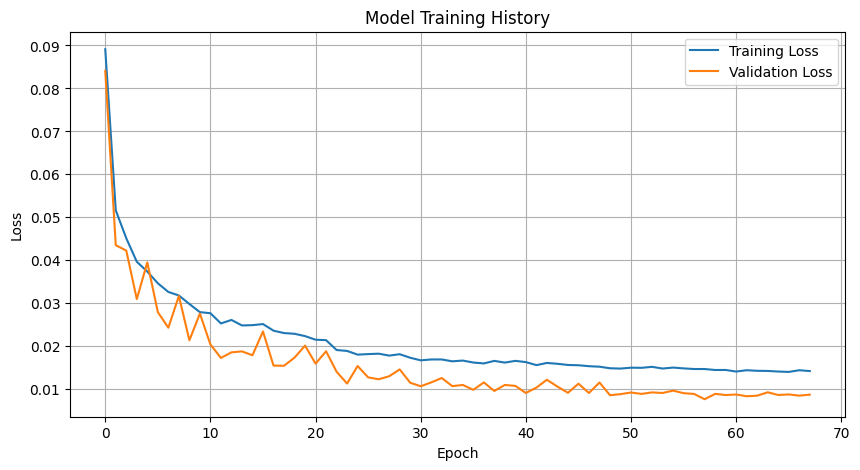

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_history.png')
plt.show()

Evaluating model...
Evaluating model performance...
30/30 [==============================] - 3s 60ms/step
Mean displacement error at speed >5 m/s: 0.0300 m
Overall mean displacement error: 0.0316 m
Final position displacement error: 0.0450 m
Average path smoothness (lower is better): 0.0116 rad
Visualizing trajectory predictions...


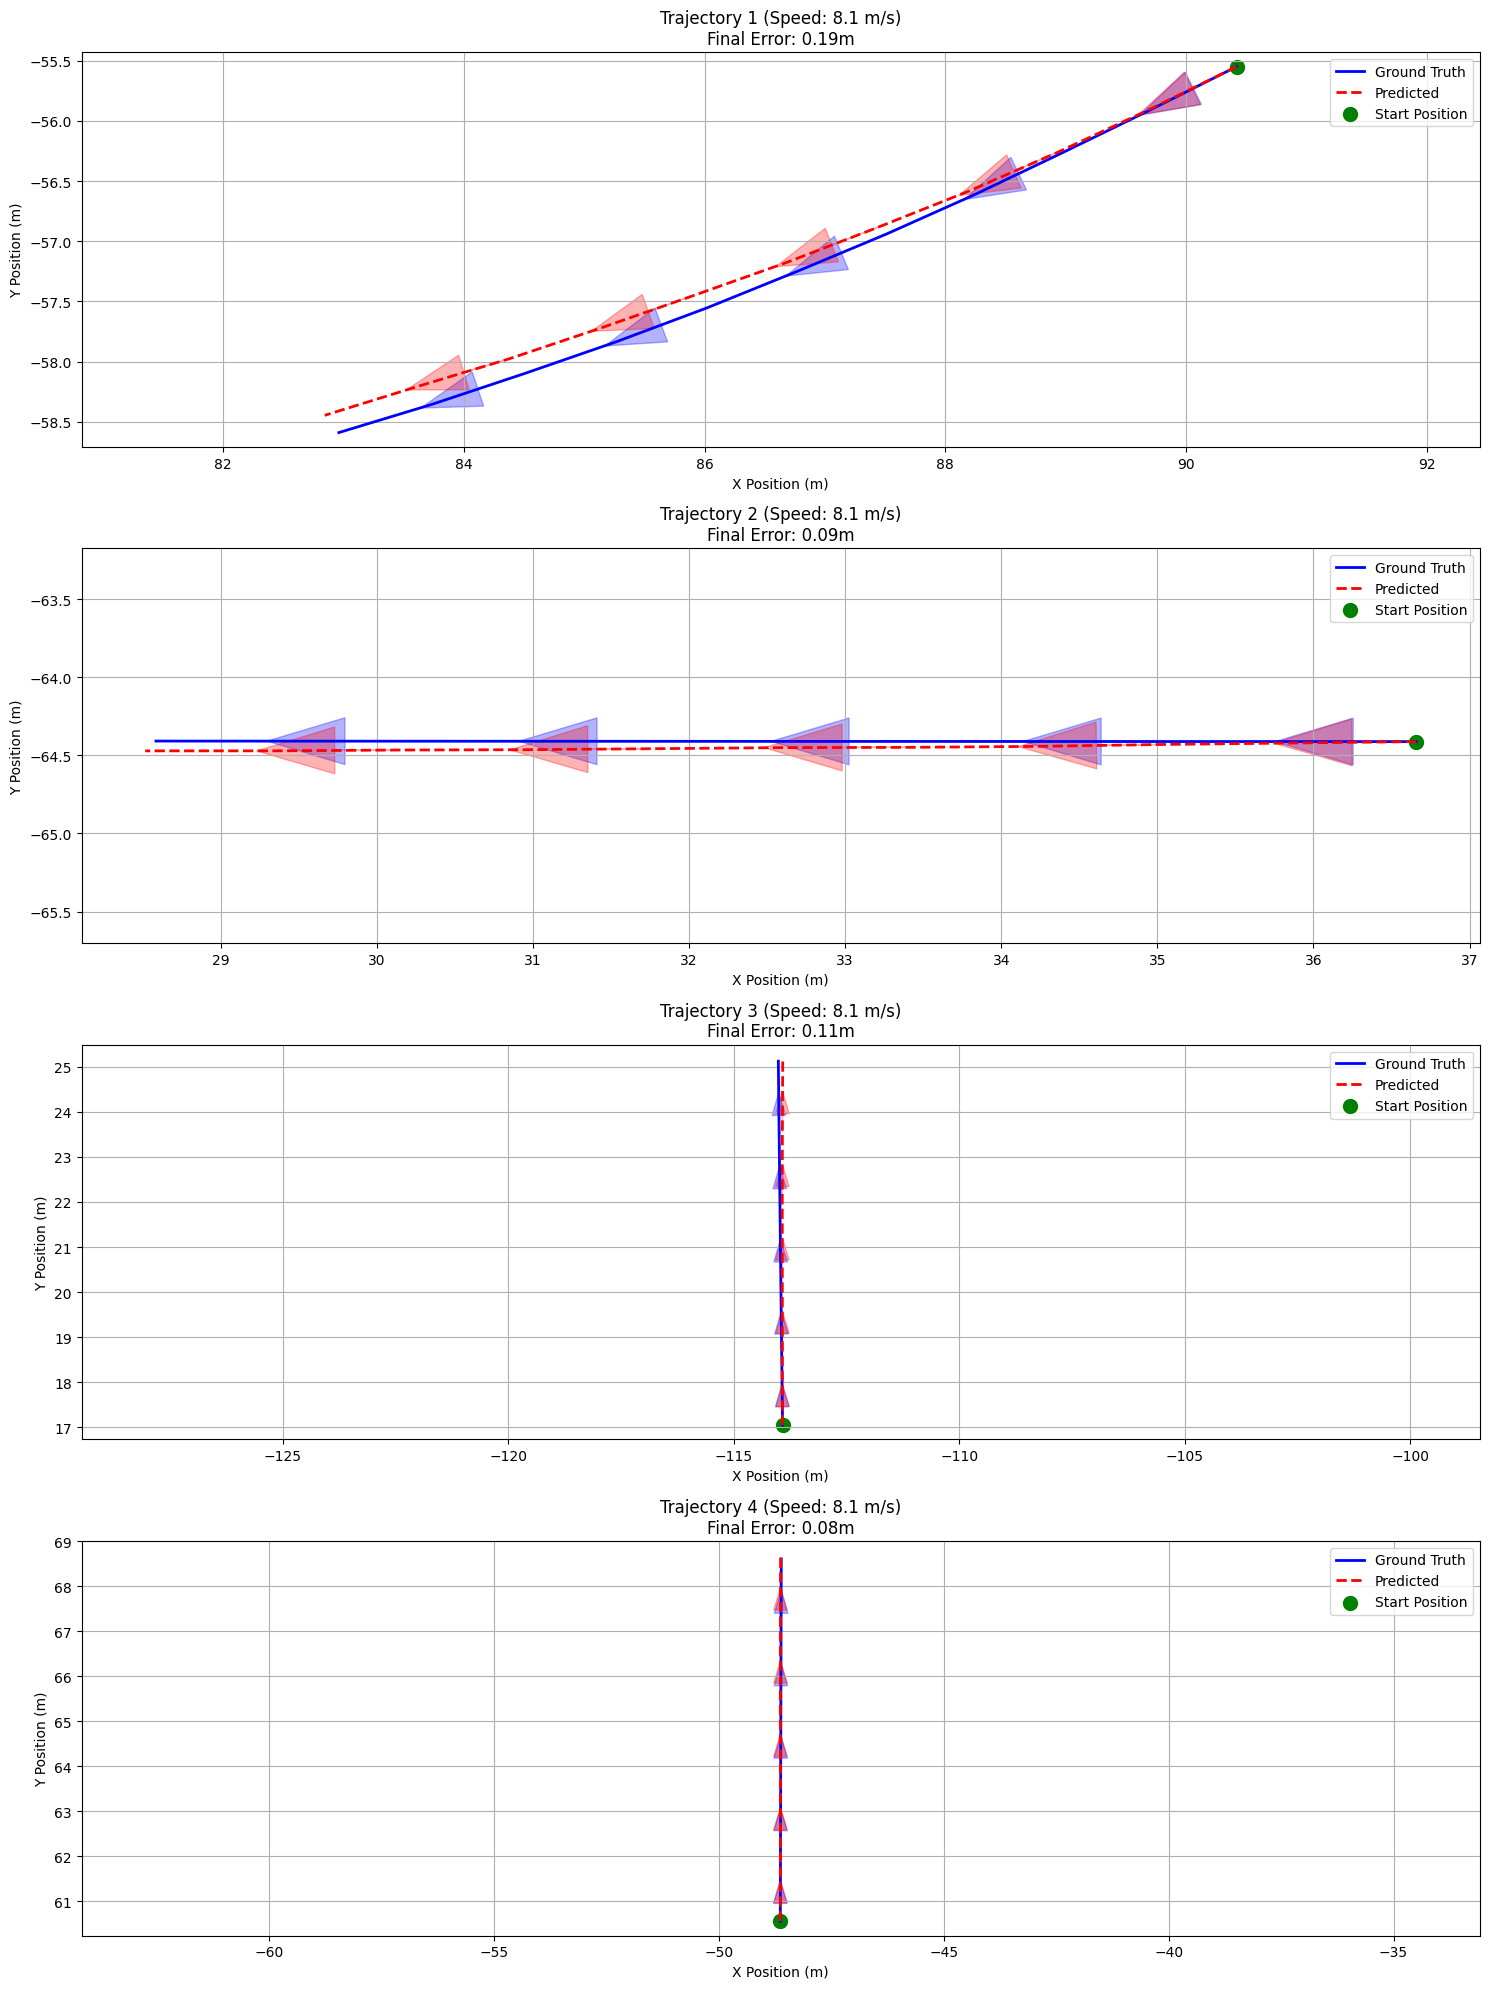

In [13]:
print("Evaluating model...")
evaluation_results = evaluate_model_performance(
        model, X_seq_test, X_lidar_test, y_test, segment_info_test, scaler_target
    )
    
# Visualize predictions
print("Visualizing trajectory predictions...")
visualize_trajectory_predictions(
        evaluation_results['ground_truth'],
        evaluation_results['predictions'],
        segment_info_test,
        n_samples=4
    )

In [14]:
model.save('trajectory_prediction_model.h5')
print("Model saved as 'trajectory_prediction_model.h5'")
    
    # Save the scalers for later use
import pickle
with open('trajectory_scalers.pkl', 'wb') as f:
    pickle.dump({
            'input_scaler': scaler_input,
            'target_scaler': scaler_target
        }, f)
print("Scalers saved as 'trajectory_scalers.pkl'")

Model saved as 'trajectory_prediction_model.h5'
Scalers saved as 'trajectory_scalers.pkl'


In [12]:
def predict_future_trajectory(model, current_sequence, current_lidar, scaler_input, scaler_target, 
                             start_x, start_y):
    """
    Predict a future trajectory given current state
    
    Args:
        model: Trained trajectory prediction model
        current_sequence: Normalized sequence of recent vehicle dynamics
        current_lidar: Processed LiDAR point cloud data
        scaler_input: Scaler used for input normalization
        scaler_target: Scaler used for target normalization
        start_x, start_y: Current vehicle position
    
    Returns:
        predicted_path: Array of absolute positions for the predicted path
    """
    # Expand dimensions for batch size
    sequence_input = np.expand_dims(current_sequence, axis=0)
    lidar_input = np.expand_dims(current_lidar, axis=0)
    
    # Get model prediction
    prediction = model.predict([sequence_input, lidar_input])
    
    # Reshape prediction for inverse transformation
    pred_reshaped = prediction.reshape(-1, 2)
    
    # Inverse transform to get real-world displacements
    pred_original = scaler_target.inverse_transform(pred_reshaped)
    
    # Reshape back
    pred_original = pred_original.reshape(prediction.shape)[0]
    
    # Convert relative displacements to absolute positions
    predicted_path = convert_relative_to_absolute(start_x, start_y, pred_original)
    
    return predicted_path

def implement_trajectory_prediction(ego_df_filtered, model, scaler_input, scaler_target, timestamp_to_lidar, 
                                  seq_length=10, prediction_horizon=10):
    """
    Implement trajectory prediction for each timestep
    
    Args:
        ego_df_filtered: Processed ego vehicle data
        model: Trained trajectory prediction model
        scaler_input, scaler_target: Scalers for normalization
        timestamp_to_lidar: Mapping of timestamps to LiDAR files
        seq_length: Length of input sequence
        prediction_horizon: Number of timesteps to predict
    
    Returns:
        DataFrame with predicted trajectories
    """
    # Select input features (must match those used in training)
    input_features = [
        'delta_x', 'delta_y',
        'velocity_x', 'velocity_y', 'speed',
        'heading', 'heading_change', 'curvature',
        'acceleration_x', 'acceleration_y', 'acceleration',
        'steering', 'throttle', 'brake',
        'is_moving'
    ]
    
    # Create output DataFrame
    prediction_df = ego_df_filtered.copy()
    prediction_df['predicted_x'] = np.nan
    prediction_df['predicted_y'] = np.nan
    
    # Loop through each segment
    for segment_id in tqdm(prediction_df['segment_id'].unique(), desc="Processing segments"):
        segment_data = prediction_df[prediction_df['segment_id'] == segment_id]
        
        # Skip segments that are too short
        if len(segment_data) < seq_length + prediction_horizon:
            continue
        
        # Process each timestep in the segment where we have enough history
        for i in range(seq_length, len(segment_data) - prediction_horizon + 1):
            # Get the indices for this sequence
            seq_indices = segment_data.index[i-seq_length:i]
            future_indices = segment_data.index[i:i+prediction_horizon]
            
            # Extract and normalize the input sequence
            input_seq = ego_df_filtered.loc[seq_indices, input_features].values
            input_seq_norm = scaler_input.transform(input_seq)
            
            # Get LiDAR data for the current timestep
            current_ts = ego_df_filtered.loc[seq_indices[-1], 'timestamp']
            if current_ts in timestamp_to_lidar:
                lidar_file = timestamp_to_lidar[current_ts]
                pointcloud = load_lidar_point_cloud(lidar_file)
                sampled_points = sample_point_cloud(pointcloud)
                processed_points = process_point_cloud(sampled_points)
            else:
                processed_points = np.zeros((1024, 4))
            
            # Get current position
            start_x = ego_df_filtered.loc[seq_indices[-1], 'x']
            start_y = ego_df_filtered.loc[seq_indices[-1], 'y']
            
            # Predict future trajectory
            predicted_path = predict_future_trajectory(
                model, input_seq_norm, processed_points, 
                scaler_input, scaler_target,
                start_x, start_y
            )
            
            # Add predicted positions to the first future position
            prediction_df.loc[future_indices[0], 'predicted_x'] = predicted_path[1, 0]
            prediction_df.loc[future_indices[0], 'predicted_y'] = predicted_path[1, 1]
    
    return prediction_df

def visualize_prediction_performance(prediction_df):
    """
    Visualize the prediction performance by comparing actual vs predicted positions
    
    Args:
        prediction_df: DataFrame with predicted positions
    """
    # Filter to only rows with predictions
    df = prediction_df.dropna(subset=['predicted_x', 'predicted_y']).copy()
    
    # Calculate position error
    df['position_error'] = np.sqrt((df['x'] - df['predicted_x'])**2 + (df['y'] - df['predicted_y'])**2)
    
    # Plot trajectory comparison
    plt.figure(figsize=(15, 10))
    
    # Plot actual vs predicted trajectory
    plt.subplot(2, 1, 1)
    plt.plot(df['x'], df['y'], 'b-', label='Actual Path', alpha=0.7)
    plt.plot(df['predicted_x'], df['predicted_y'], 'r--', label='Predicted Path', alpha=0.7)
    plt.title('Actual vs Predicted Trajectory')
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    
    # Plot position error over time
    plt.subplot(2, 1, 2)
    plt.plot(df.index, df['position_error'], 'g-', label='Position Error')
    plt.title('Position Prediction Error Over Time')
    plt.xlabel('Index')
    plt.ylabel('Position Error (m)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('prediction_performance.png')
    plt.show()
    
    # Print summary statistics
    print(f"Mean position error: {df['position_error'].mean():.4f} m")
    print(f"Max position error: {df['position_error'].max():.4f} m")
    print(f"Std position error: {df['position_error'].std():.4f} m")
    
    # Analyze performance at different speeds
    speed_bins = [0, 5, 10, 20, 30, float('inf')]
    for i in range(len(speed_bins)-1):
        bin_data = df[(df['speed'] >= speed_bins[i]) & (df['speed'] < speed_bins[i+1])]
        if len(bin_data) > 0:
            print(f"Speed {speed_bins[i]}-{speed_bins[i+1]} m/s:")
            print(f"  Mean position error: {bin_data['position_error'].mean():.4f} m")
            print(f"  Number of samples: {len(bin_data)}")

def create_interactive_trajectory_visualization(ego_df_filtered, prediction_df):
    """
    Create an interactive visualization of vehicle trajectories
    
    Args:
        ego_df_filtered: Processed ego vehicle data
        prediction_df: DataFrame with predicted trajectories
    """
    try:
        import plotly.graph_objects as go
        from plotly.subplots import make_subplots
    except ImportError:
        print("Plotly not installed. Install with 'pip install plotly' for interactive visualization.")
        return
    
    # Create a figure with subplots
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=("Vehicle Trajectory", "Speed Profile")
    )
    
    # Filter to only rows with predictions
    df = prediction_df.dropna(subset=['predicted_x', 'predicted_y']).copy()
    
    # Add trajectory plot
    fig.add_trace(
        go.Scatter(
            x=df['x'], 
            y=df['y'],
            mode='lines+markers',
            name='Actual Path',
            marker=dict(size=5, color='blue')
        ),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x=df['predicted_x'], 
            y=df['predicted_y'],
            mode='lines+markers',
            name='Predicted Path',
            marker=dict(size=5, color='red')
        ),
        row=1, col=1
    )
    
    # Add speed profile plot
    fig.add_trace(
        go.Scatter(
            x=df.index, 
            y=df['speed'],
            mode='lines',
            name='Speed (m/s)',
            line=dict(color='green')
        ),
        row=1, col=2
    )
    
    # Update layout
    fig.update_layout(
        title='Vehicle Trajectory Prediction Visualization',
        height=600,
        width=1200,
        showlegend=True,
        legend=dict(x=0, y=-0.2, orientation='h')
    )
    
    # Make the trajectory plot have equal axes
    fig.update_yaxes(scaleanchor="x", scaleratio=1, row=1, col=1)
    
    # Add axis labels
    fig.update_xaxes(title_text="X Position (m)", row=1, col=1)
    fig.update_yaxes(title_text="Y Position (m)", row=1, col=1)
    
    fig.update_xaxes(title_text="Index", row=1, col=2)
    fig.update_yaxes(title_text="Speed (m/s)", row=1, col=2)
    
    # Save as HTML file
    fig.write_html("interactive_trajectory_visualization.html")
    print("Interactive visualization saved as 'interactive_trajectory_visualization.html'")
    
    return fig

# Real Time example : 

In [14]:
print("Loading trained model for control implementation...")
model = keras.models.load_model('model/trajectory_prediction_model.h5', 
                                   custom_objects={'weighted_displacement_loss': weighted_displacement_loss})

Loading trained model for control implementation...


In [16]:
import pickle
with open('model/trajectory_scalers.pkl', 'rb') as f:
    scalers = pickle.load(f)
    scaler_input = scalers['input_scaler']
    scaler_target = scalers['target_scaler']

In [19]:
print("Implementing trajectory control...")
ego_df_dynamics = calculate_vehicle_dynamics(ego_df)
ego_df_relative = calculate_relative_displacement(ego_df_dynamics)
ego_df_filtered = filter_and_segment_data(ego_df_relative)
timestamp_to_lidar = map_timestamps_to_lidar(ego_df_filtered, lidar_path)

# Implement trajectory control
control_df = implement_trajectory_prediction(
        ego_df_filtered, model, scaler_input, scaler_target, timestamp_to_lidar
    )

Implementing trajectory control...


Processing segments:   0%|          | 0/41 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Processing segments:   7%|▋         | 3/41 [00:20<04:20,  6.86s/it]

1/1 [==============================] - 0s 33ms/step


Processing segments:  10%|▉         | 4/41 [00:45<07:50, 12.72s/it]

1/1 [==============================] - 0s 39ms/step


Processing segments:  15%|█▍        | 6/41 [00:57<05:34,  9.56s/it]

1/1 [==============================] - 0s 36ms/step


Processing segments:  17%|█▋        | 7/41 [01:26<08:12, 14.50s/it]

1/1 [==============================] - 0s 32ms/step


Processing segments:  20%|█▉        | 8/41 [01:35<07:07, 12.94s/it]

1/1 [==============================] - 0s 30ms/step


Processing segments:  22%|██▏       | 9/41 [02:01<08:51, 16.60s/it]

1/1 [==============================] - 0s 31ms/step


Processing segments:  24%|██▍       | 10/41 [02:53<13:44, 26.59s/it]

1/1 [==============================] - 0s 26ms/step


Processing segments:  27%|██▋       | 11/41 [03:25<14:02, 28.07s/it]

1/1 [==============================] - 0s 28ms/step


Processing segments:  29%|██▉       | 12/41 [03:32<10:41, 22.11s/it]

1/1 [==============================] - 0s 24ms/step


Processing segments:  32%|███▏      | 13/41 [03:33<07:20, 15.73s/it]

1/1 [==============================] - 0s 27ms/step


Processing segments:  34%|███▍      | 14/41 [03:37<05:32, 12.33s/it]

1/1 [==============================] - 0s 29ms/step


Processing segments:  37%|███▋      | 15/41 [04:13<08:22, 19.34s/it]

1/1 [==============================] - 0s 35ms/step


Processing segments:  39%|███▉      | 16/41 [04:43<09:26, 22.65s/it]

1/1 [==============================] - 0s 45ms/step


Processing segments:  41%|████▏     | 17/41 [04:51<07:15, 18.14s/it]

1/1 [==============================] - 0s 45ms/step


Processing segments:  44%|████▍     | 18/41 [05:20<08:09, 21.29s/it]

1/1 [==============================] - 0s 37ms/step


Processing segments:  46%|████▋     | 19/41 [05:33<06:57, 18.96s/it]

1/1 [==============================] - 0s 37ms/step


Processing segments:  51%|█████     | 21/41 [05:52<04:53, 14.67s/it]

1/1 [==============================] - 0s 40ms/step


Processing segments:  54%|█████▎    | 22/41 [06:27<06:13, 19.66s/it]

1/1 [==============================] - 0s 48ms/step


Processing segments:  56%|█████▌    | 23/41 [07:13<07:56, 26.47s/it]

1/1 [==============================] - 0s 39ms/step


Processing segments:  59%|█████▊    | 24/41 [07:19<05:57, 21.02s/it]

1/1 [==============================] - 0s 37ms/step


Processing segments:  61%|██████    | 25/41 [07:30<04:48, 18.06s/it]

1/1 [==============================] - 0s 39ms/step


Processing segments:  66%|██████▌   | 27/41 [07:33<02:28, 10.64s/it]

1/1 [==============================] - 0s 53ms/step


Processing segments:  68%|██████▊   | 28/41 [07:59<03:09, 14.56s/it]

1/1 [==============================] - 0s 38ms/step


Processing segments:  71%|███████   | 29/41 [08:05<02:26, 12.25s/it]

1/1 [==============================] - 0s 42ms/step


Processing segments:  73%|███████▎  | 30/41 [08:43<03:30, 19.13s/it]

1/1 [==============================] - 0s 47ms/step


Processing segments:  76%|███████▌  | 31/41 [09:20<04:00, 24.04s/it]

1/1 [==============================] - 0s 44ms/step


Processing segments:  78%|███████▊  | 32/41 [10:51<06:27, 43.03s/it]

1/1 [==============================] - 0s 55ms/step


Processing segments:  80%|████████  | 33/41 [11:38<05:53, 44.14s/it]

1/1 [==============================] - 0s 46ms/step


Processing segments:  83%|████████▎ | 34/41 [12:14<04:53, 41.95s/it]

1/1 [==============================] - 0s 50ms/step


Processing segments:  88%|████████▊ | 36/41 [13:52<03:45, 45.11s/it]

1/1 [==============================] - 0s 49ms/step


Processing segments:  90%|█████████ | 37/41 [14:39<03:01, 45.43s/it]

1/1 [==============================] - 0s 53ms/step


Processing segments:  93%|█████████▎| 38/41 [15:08<02:03, 41.32s/it]

1/1 [==============================] - 0s 69ms/step


Processing segments:  95%|█████████▌| 39/41 [15:45<01:20, 40.01s/it]

1/1 [==============================] - 0s 56ms/step


Processing segments:  98%|█████████▊| 40/41 [16:04<00:34, 34.19s/it]

1/1 [==============================] - 0s 60ms/step


Processing segments: 100%|██████████| 41/41 [16:24<00:00, 24.00s/it]


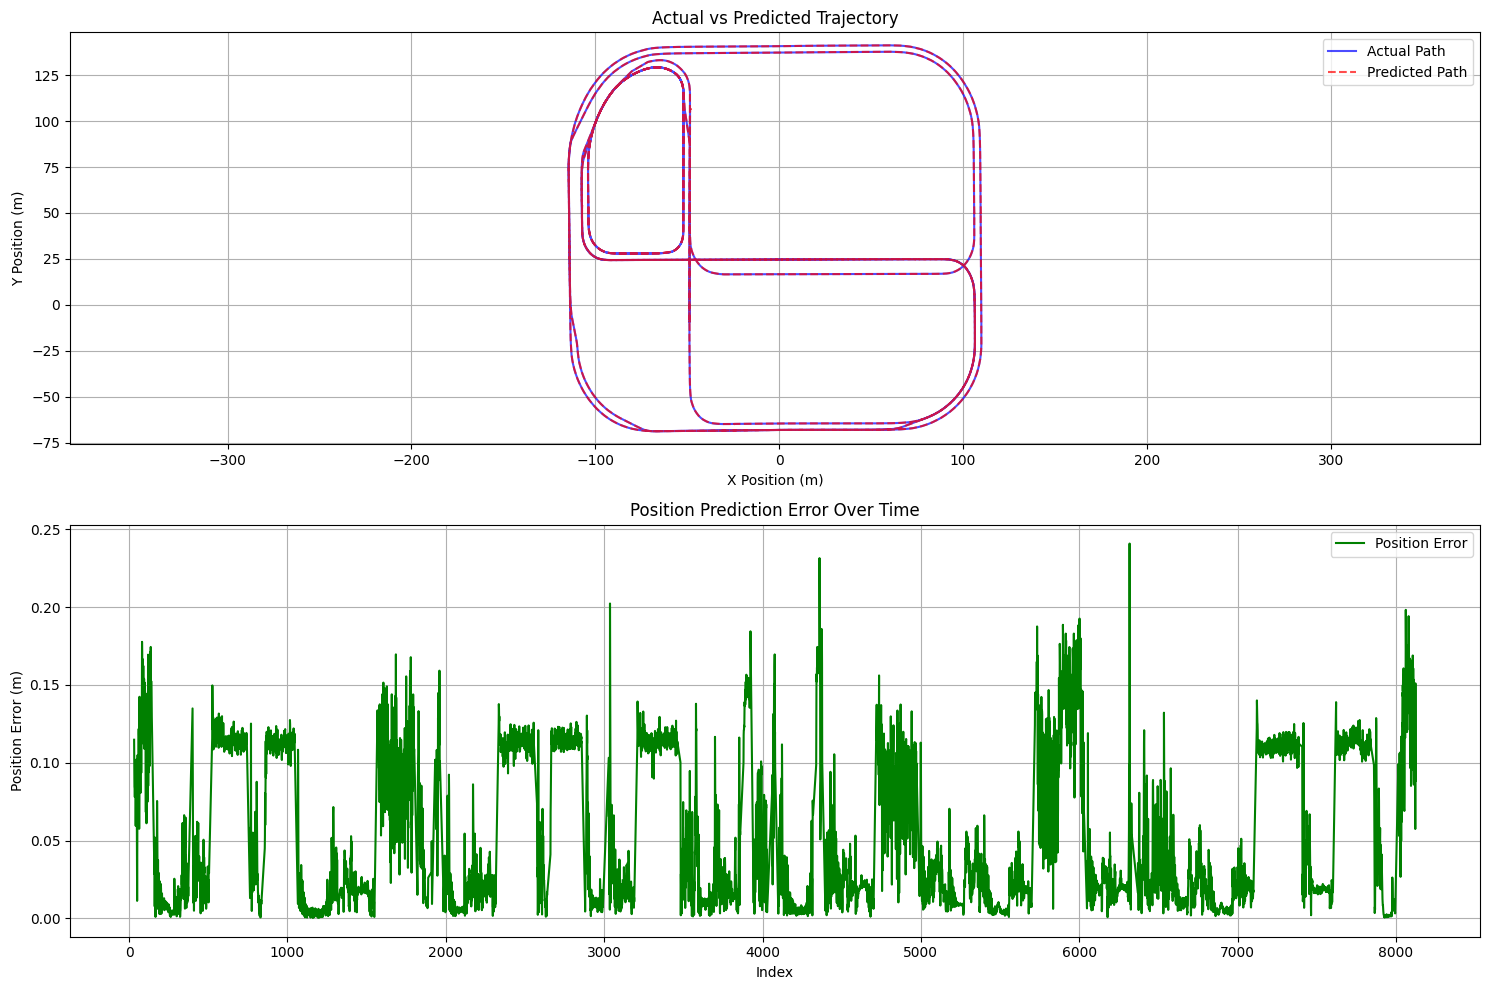

Mean position error: 0.0549 m
Max position error: 0.2408 m
Std position error: 0.0480 m
Speed 0-5 m/s:
  Mean position error: 0.0993 m
  Number of samples: 3209
Speed 5-10 m/s:
  Mean position error: 0.0208 m
  Number of samples: 4185


In [20]:
visualize_prediction_performance(control_df)

In [21]:
create_interactive_trajectory_visualization(ego_df_filtered, control_df)

Interactive visualization saved as 'interactive_trajectory_visualization.html'
